**Chọn tập dữ liệu: MBA Admission**

Mô tả tập dữ liệu
1. Nguồn dữ liệu:
Dữ liệu tổng hợp được tạo từ số liệu thống kê của Lớp Wharton năm 2025.

2. Siêu dữ liệu:
 * application_id: Mã định danh duy nhất cho mỗi đơn đăng ký
 * gender: Giới tính của ứng viên (Nam, Nữ)
 * international: Sinh viên quốc tế (ĐÚNG/SAI)
 * gpa: Điểm trung bình tích lũy của ứng viên (trên thang điểm 4.0)
 * major: Chuyên ngành đại học (Kinh doanh, STEM, Khoa học nhân văn)
 * race: Xuất thân chủng tộc của ứng viên (ví dụ: Da trắng, Da đen, Châu Á, Người gốc Tây Ban Nha, Khác / null: sinh viên quốc tế)
 * gmat: Điểm GMAT của ứng viên (800 điểm)
 * work_exp: Số năm kinh nghiệm làm việc (Năm)
 * work_industry: Ngành nghề có kinh nghiệm làm việc trước đây của ứng viên (ví dụ: Tư vấn, Tài chính, Công nghệ, v.v.)
 * admission: Trạng thái tuyển sinh (Được nhận, Danh sách chờ, Null: Từ chối)

# Mô tả bài toán: dự đoán trạng thái nhập học

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#for preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

#for evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#models
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, silhouette_visualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Tải dữ liệu
df = pd.read_csv('/content/drive/MyDrive/MachineLearning/MBA Admission dataset/MBA.csv')

In [25]:
# Kiểm tra dữ liệu
df.head(10)

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN
5,6,Male,False,3.18,Business,White,610.0,6.0,Consulting,NaN
6,7,Female,False,2.93,STEM,Other,590.0,3.0,Technology,Admit
7,8,Male,True,3.02,Business,NaN,630.0,6.0,Financial Services,NaN
8,9,Male,False,3.24,Business,White,590.0,2.0,Nonprofit/Gov,NaN
9,10,Male,False,3.27,Humanities,Asian,690.0,3.0,Consulting,NaN


In [26]:
#kiểm tra và tổng hợp số lượng giá trị bị thiếu
df.isnull().sum()

,0
application_id,0
gender,0
international,0
gpa,0
major,0
race,1842
gmat,0
work_exp,0
work_industry,0
admission,5194


In [27]:
#Loại bỏ các hàng có giá trị bị thiếu.
df=df.dropna()
#Kiểm tra số lượng giá trị bị thiếu sau khi loại bỏ
df.isna().sum()

,0
application_id,0
gender,0
international,0
gpa,0
major,0
race,0
gmat,0
work_exp,0
work_industry,0
admission,0


In [28]:
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
6,7,Female,False,2.93,STEM,Other,590.0,3.0,Technology,Admit
12,13,Female,False,3.24,Humanities,Hispanic,640.0,6.0,PE/VC,Waitlist
14,15,Female,False,3.03,STEM,White,600.0,5.0,Technology,Admit
16,17,Female,False,3.32,Business,Asian,710.0,5.0,PE/VC,Admit


In [29]:
#Loại bỏ cột application_id
df=df.drop('application_id',axis=1)

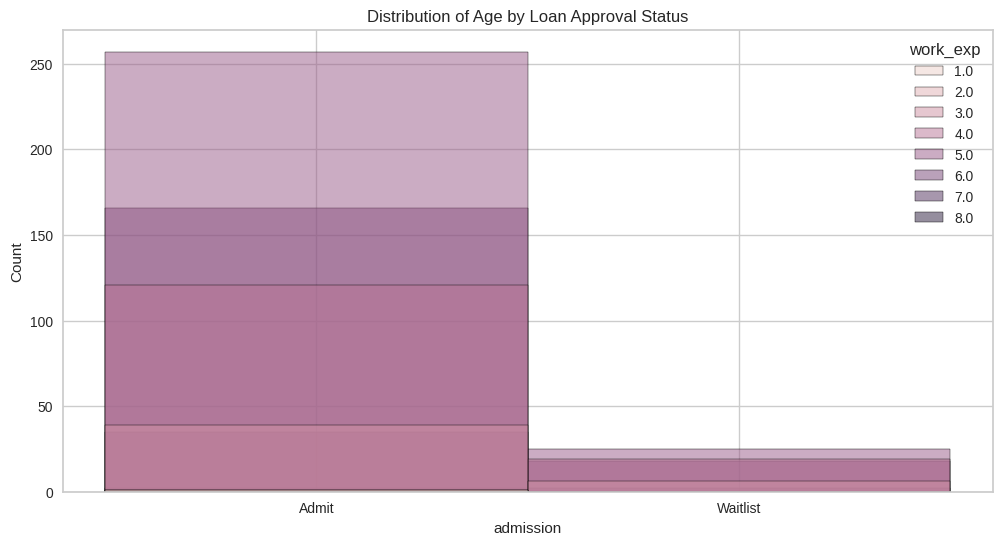

In [30]:
#tạo biểu đồ histogram hiển thị phân bố của cột admission, phân loại theo kinh nghiệm làm việc (work_exp)
plt.figure(figsize=(12,6))
sns.histplot(data=df,x='admission', hue='work_exp')
plt.title("Distribution of Age by Loan Approval Status")
plt.show()

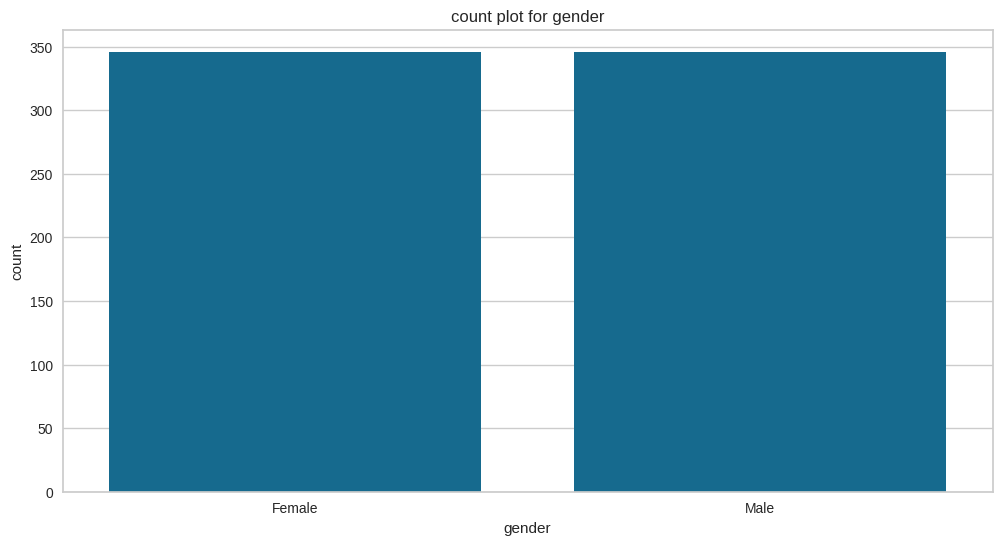

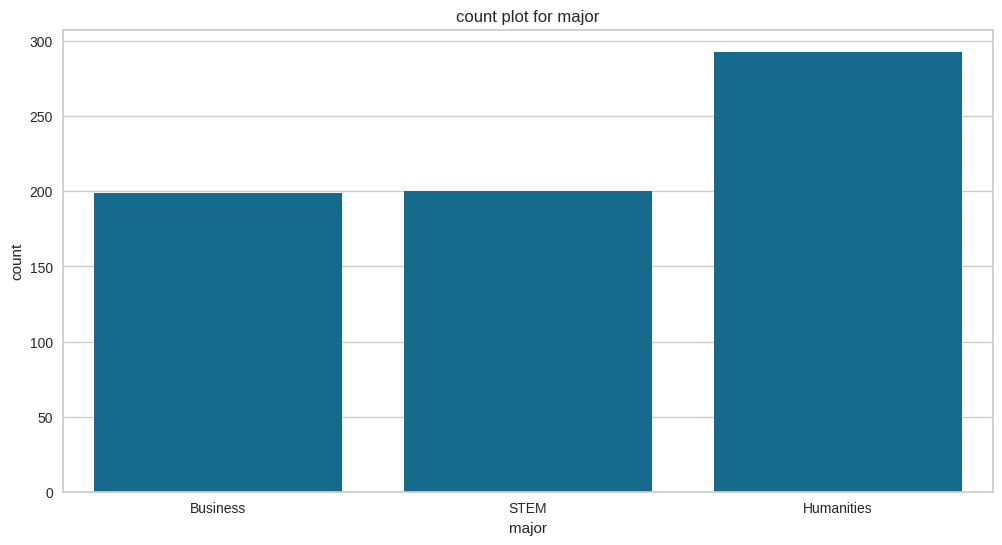

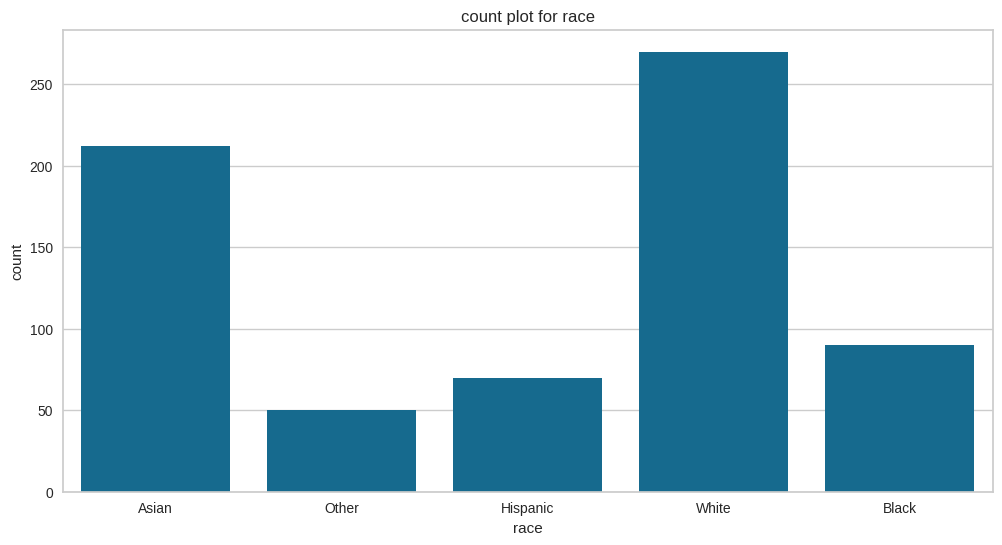

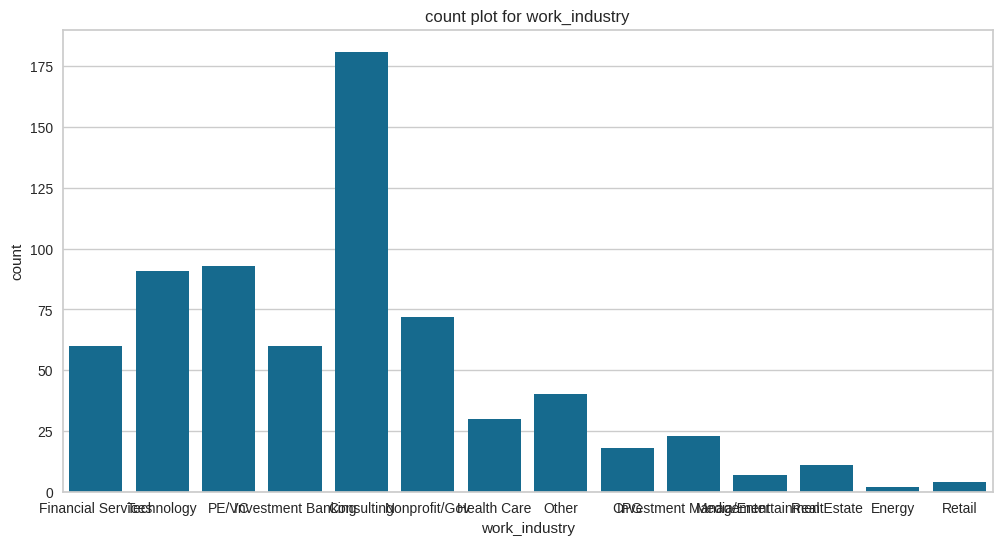

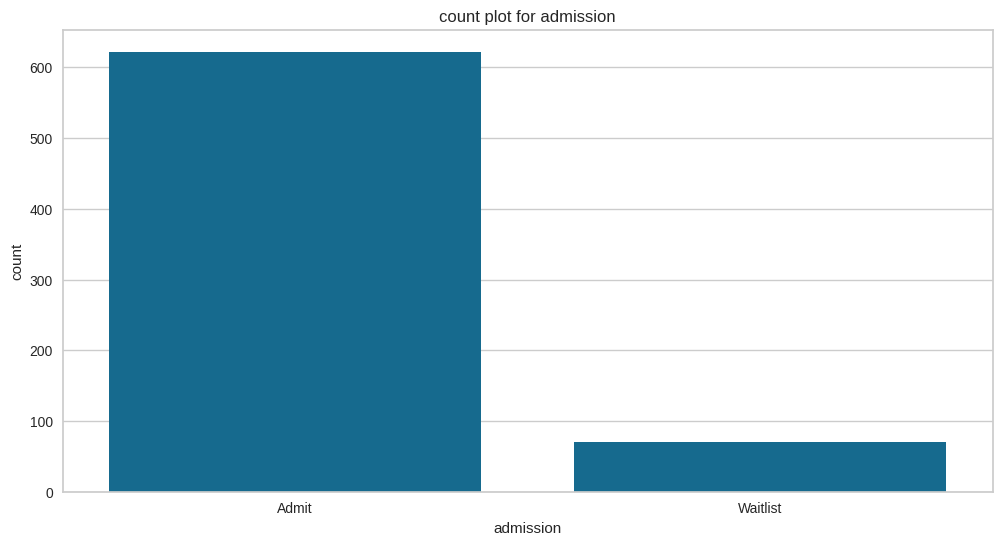

In [31]:
#vẽ biểu đồ cột (count plot) cho tất cả các cột kiểu 'object' trong DataFrame df, hiển thị số lượng các giá trị duy nhất
for cols in df.select_dtypes('object').columns :
    plt.figure(figsize=(12,6))
    sns.countplot(data=df, x=cols )
    plt.title(f"count plot for {cols}")
    plt.show()

In [32]:
#Tạo biến x chứa tất cả các cột trong DataFrame df ngoại trừ cột admission.
x=df.drop('admission', axis =1)
#Tạo biến y chứa cột admission từ DataFrame df.
y=df['admission']

In [33]:
#sử dụng LabelEncoder để mã hóa các cột kiểu 'object' trong biến x, chuyển đổi các giá trị phân loại thành số nguyên.
le=LabelEncoder()
for cols in x.select_dtypes('object').columns:
    x[cols]=le.fit_transform(x[cols])

In [34]:
y=le.fit_transform(y)

In [35]:
## Chia dữ liệu
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [36]:
# Huấn luyện mô hình
models = {
    'Linear_Regression':LinearRegression(),
}

In [37]:
## Tính toán các chỉ số đánh giá
results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1-Score': []}


for i in models:
    obj = models[i]
    obj.fit(x_train, y_train)
    obj_pred = obj.predict(x_test)


    accuracy = accuracy_score(y_test, obj_pred>0.5)
    precision = precision_score(y_test, obj_pred>0.5,average='weighted')
    recall = recall_score(y_test, obj_pred>0.5,average='weighted')
    f1 = f1_score(y_test, obj_pred>0.5,average='weighted')


    results['Model'].append(i)
    results['Accuracy'].append(accuracy)
    results['Precision'].append(precision)
    results['Recall'].append(recall)
    results['F1-Score'].append(f1)


results_df = pd.DataFrame(results)


print(results_df)

               Model  Accuracy  Precision    Recall  F1-Score
0  Linear_Regression  0.884892   0.783034  0.884892  0.830853
